Question:
How does increased life expectancy impact population and age demographics?

In [62]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [63]:
#read csv file that contains our data for world population, life expectancy, and fertility rate
from pandas import read_csv
filename = 'project1data.csv'
tables = read_csv(filename, header=0, index_col=0, decimal='M');

In [76]:
def plot_results(un, ts_young, ts_middle, timeseries, title):
    """Plot the estimates and the model.
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(un, '--', label='UN DESA')
    plot(ts_young, color='blue', label='ages 0-14')
    plot(ts_middle, color='black', label='ages 15-44')
    plot(timeseries, color='green', label='ages 45+')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

In [65]:
#Our notebook was confused by decimals so within our data set we multiplied our numbers by 1000 
#in order to get rid of the decimals, so we then had to divide by 1000
life_expectancy = tables._expectancyx1000/1000
birth_rate = tables.birthrate10000/10000
fer_rate = tables.fer_ratex1000/1000
un = tables.UN / 1e9;

In [66]:
young = get_first_value(un) * 0.378
old= get_first_value(un) * 0.2
middle = get_first_value(un)*0.422
init = State(young=young, middle=middle, old=old);

In [67]:
death_rate = 1/((life_expectancy)-44)
birth_rate = fer_rate/(31*2);
#children per woman in her fer age per year

In [68]:
system = System(mature_rate = 1/14,
                elder_rate = 1/31,
                t_0 = 1965,
                t_end = 2016,
                init=init);

In [69]:
def update_func1(state, t, system):
    birth_rate2 = birth_rate[t]
    births = birth_rate2*state.middle
    maturings = system.mature_rate * state.young
    agings = system.elder_rate * state.middle
    death_rate2 = death_rate[t]
    deaths = death_rate2 * state.old
    young = state.young + births - maturings
    middle = state.middle + maturings - agings
    old = state.old + agings - deaths
    
    return State(young=young, middle=middle, old=old)
    

In [70]:
state = update_func1(init, system.t_0, system)

,values
young,1.282386
middle,1.449457
old,0.639248


In [71]:
state = update_func1(state, system.t_0, system);

In [72]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    init: initial State object
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results_young = TimeSeries()
    results_middle = TimeSeries()
    
    state = system.init
    results[system.t_0] = state.young + state.middle + state.old
    
    for t in linrange(system.t_0, system.t_end):
        state = update_func(state, t, system)
        results[t+1] = state.young + state.middle + state.old
        results_young[t+1] = state.young
        results_middle[t+1] = state.young + state.middle
        
    return results, results_young, results_middle

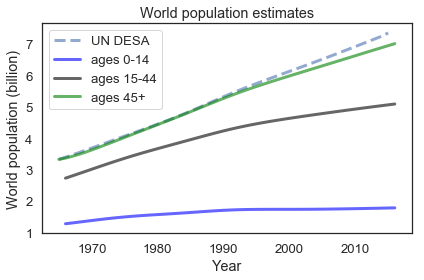

In [77]:
results = run_simulation(system, update_func1)[0];
results_young = run_simulation(system, update_func1)[1];
results_middle = run_simulation(system, update_func1)[2];
plot_results(un, results_young, results_middle, results, 'World population estimates')

Interpretation:
